In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os
%matplotlib inline

In [58]:
# Camera calibration
def calibrate_camera(images, draw_corners=None):
    '''
    Calibarate the camera with a list of images
    
    Params:
    images: a list of images taken by the camera, used to calibrate the camera
    draw_corners: if true, draw the found corners on the image
    
    Return: camera matrix, distortion coefficient
    '''
    # Two lists to store object points and image points
    objpoints = []
    imgpoints = []
    
    # Prepare object points
    objp = np.zeros([6*9, 3], np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    # Step through each image
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
        
        # If found corners, add the image points and correponding object points
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # If needed, draw the corners on the image
            if draw_corners == True:
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img) 
    
    # Calibrate camera with object points and image points
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    return mtx, dist  

def load_calibration_params(file):
    '''
    params: 
    file: pickle file (.p) including the camera matrix and undistion coefficient
    '''
    if os.path.exists(file):
        with open(file, 'rb') as f:
            mtx, dist = pickle.load(f)
    else:
        images = glob.glob('./camera_cal/calibration*.jpg')
        mtx, dist = calibrate_camera(images)
        with open(file, 'wb') as f:
            pickle.dump((mtx, dist), f)
    return mtx, dist

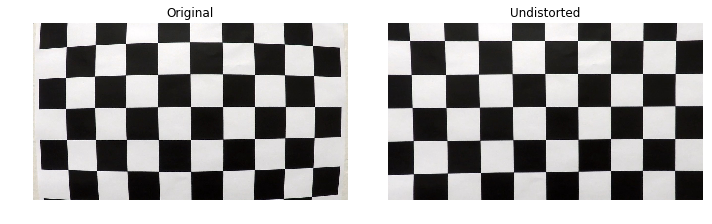

In [60]:
# Visualize the chessboard undistortion 
file = './undistortion.p'
mtx, dist = load_calibration_params(file)

img = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
fig = plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img), plt.title('Original'), plt.axis('off')
plt.subplot(122), plt.imshow(undist), plt.title('Undistorted'), plt.axis('off')
test_img_output_folder = './output_images/'
if not os.path.isdir(test_img_output_folder):
    os.mkdir(test_img_output_folder)
output_path = os.path.join(test_img_output_folder, 'chessboard_undistort.png')
plt.tight_layout()
plt.savefig(output_path)

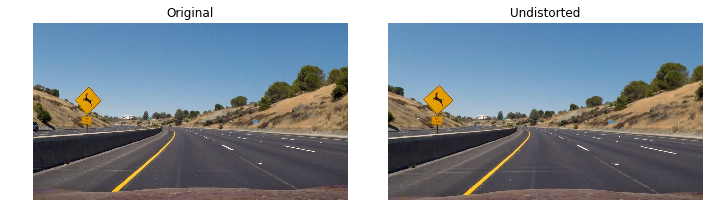

In [61]:
# Test the function with a sample image
img = mpimg.imread('./test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

fig = plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img), plt.title('Original'), plt.axis('off')
plt.subplot(122), plt.imshow(undist), plt.title('Undistorted'), plt.axis('off')
test_img_output_folder = './output_images/'
if not os.path.isdir(test_img_output_folder):
    os.mkdir(test_img_output_folder)
output_path = os.path.join(test_img_output_folder, 'undistort_output.png')
plt.tight_layout()
plt.savefig(output_path)

In [62]:
# Threshold the image with gradients and color 
def threshold_image(img, color_channel='V', color_threshold=(0,255)):
    '''
    Threshold with color filters
    ----
    Params:
    img: an undistorted image
    color_channel: hsv color space, choose either 'S' or 'V', default is 'V'
    color_threshold: color threshold to filter the lane line points
    ----
    Return: a binary file with visible lane lines
    '''
    
    # Normalize the img values to 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # HSV channel split
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    channel_params = {'H':H, 'S':S, 'V':V}
    # Store the chosen channel in channel array
    channel = np.copy(channel_params[color_channel])
    #Normalize the values of the chosen channel
    channel = cv2.normalize(channel, None, 0, 255, cv2.NORM_MINMAX)
    # Get color filter mask
    mask_color = (channel>color_threshold[0])&(channel<=color_threshold[1])
    
    # Apply the mask and get the binary
    binary = np.zeros_like(channel)
    binary[mask_color]=1
    
    return binary#

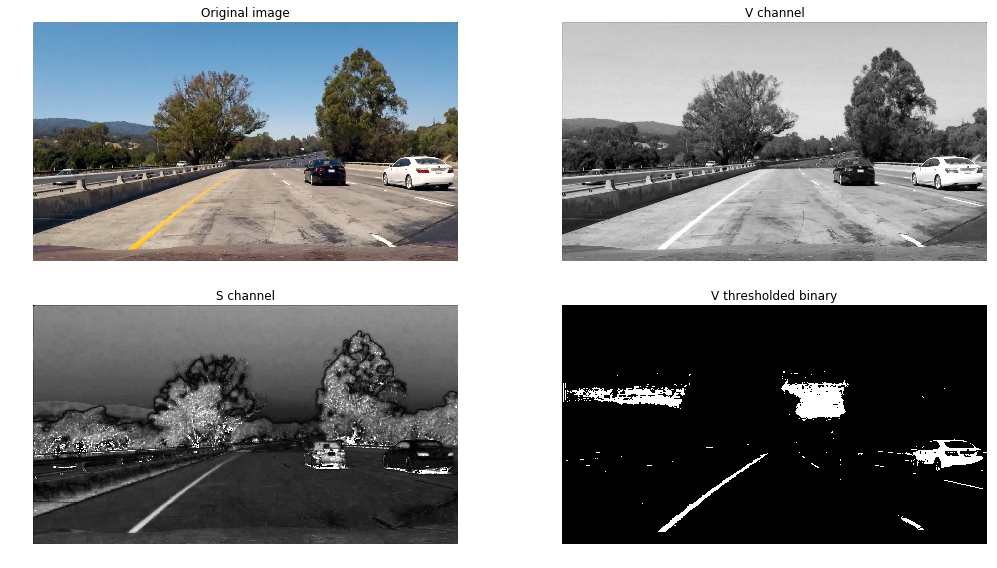

In [63]:
# Test threshold_image function
image = './test_images/test1.jpg'
img = mpimg.imread(image)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

binary = threshold_image(img, color_channel='V', color_threshold=(220,255))

fig = plt.figure(figsize=(15,8))

plt.subplot(221), plt.imshow(img), plt.title('Original image'), plt.axis('off')
plt.subplot(222), plt.imshow(V, cmap='gray'), plt.title('V channel'), plt.axis('off')
plt.subplot(223), plt.imshow(S, cmap='gray'), plt.title('S channel'), plt.axis('off')
plt.subplot(224), plt.imshow(binary, cmap='gray'), plt.title('V thresholded binary'), plt.axis('off')

plt.tight_layout()
fig.savefig('./output_images/thresholded.png')

In [64]:
# Perspective transform
def transform_perspective(src, dst):
    '''
    Transform the binary image to bird's view
    
    Params:
    binary: a binary file thresholded from the input image
    
    Return: bird's view warped binary
    '''
    # Compute transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Mint = cv2.getPerspectiveTransform(dst, src)
    return M, Mint    

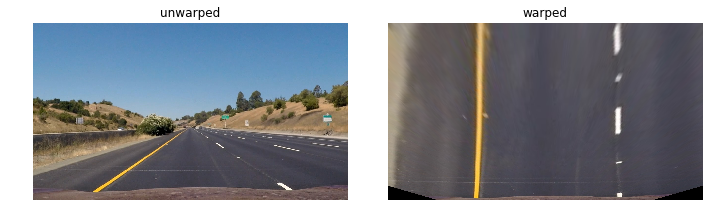

In [67]:
# Test perspective transform

# Four source points
src = np.float32(
      [[215, 705],
      [576, 460],
      [705, 460],
      [1098, 705]])

# Four destination points
dst = np.float32(
     [[350, 720],
      [350, 0],
      [950, 0],
      [950, 720]])

img = mpimg.imread('./test_images/straight_lines1.jpg')
M, Mint = transform_perspective(src, dst)
warped = cv2.warpPerspective(img, M, img.shape[::-1][1:])

fig = plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img), plt.title('unwarped'), plt.axis('off')
plt.subplot(122), plt.imshow(warped), plt.title('warped'), plt.axis('off')
plt.tight_layout()

# fig.savefig('./output_images/road_transformed.png')


In [68]:
def blind_search(warped_binary, nb_window=9, margin=100, minpixel=30):
    '''
    Search the lane line points from scratch. Start from the bottom with the strongest histogram values
    
    Params:
    warped_binary: a thresholded binary image
    nb_window: the number of windows used to perform the points search, which determines the height of the search window
    margin: the width of the search window
    minpixel: the minimum of pixels that can be recognized as lane line points
    
    return: either (True, left_fit array and right_fit array) or (False, None, None)
    '''
   
    h, w = warped_binary.shape[0], warped_binary.shape[1]
    window_height = np.int(h/nb_window)
    
    # Calcualte the starting position of the two lane lines with histogram counts
    histogram = np.sum(warped_binary[h//2:,:], axis=0)
    out_img = np.dstack([warped_binary, warped_binary, warped_binary])*255
    mid_point = np.int(w/2)
    leftx_base = np.argmax(histogram[:mid_point])
    rightx_base = np.argmax(histogram[mid_point:])+mid_point
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    nonzeros = warped_binary.nonzero()
    nonzeroy = np.array(nonzeros[0])
    nonzerox = np.array(nonzeros[1])
    
    left_lane_inds = []
    right_lane_inds = []
    
    # Loop through the height
    for window in range(nb_window):
        ylow = h - (window+1)*window_height
        yhigh = h - window*window_height
        leftx_low = leftx_current - margin
        leftx_high = leftx_current + margin
        rightx_low = rightx_current - margin
        rightx_high = rightx_current + margin
        
        cv2.rectangle(out_img, (leftx_low, ylow), (leftx_high, yhigh), (0, 255, 0), 3)
        cv2.rectangle(out_img, (rightx_low, ylow), (rightx_high, yhigh), (0, 255, 0), 3)
        
        # Get lane line coordinates indices boolean masks
        good_left_inds = ((nonzerox>=leftx_low)&(nonzerox<leftx_high)&(nonzeroy>=ylow)&(nonzeroy<yhigh)).nonzero()[0]
        good_right_inds = ((nonzerox>=rightx_low)&(nonzerox<rightx_high)&(nonzeroy>=ylow)&(nonzeroy<yhigh)).nonzero()[0]
        
       
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds)>minpixel:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpixel:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
   
    # Concatenate the indices together
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Filter the lane line coordinates
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if lefty.size>0 and righty.size>0:
        ret = True
        # Fit the points of both lane line
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    elif lefty.size>0:
        ret = True
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.copy(left_fit)
    elif righty.size>0:
        ret = True
        right_fit = np.polyfit(righty, rightx, 2)
        left_fit = np.copy(right_fit)
    else:
        ret = False
        left_fit, right_fit = np.array([]), np.array([])
    return ret, left_fit, right_fit, out_img


def adjacent_search(warped_binary, left_fit, right_fit, margin):
    '''
    Find the points close to the last fitted lane line and fit the lane line points.
    '''
    # Define a function to get the new polynomial coefficients
    def polyfit(last_fitting):
        A, B, C = last_fitting[0], last_fitting[1], last_fitting[2]
        # Store all the non zeros points
        nonzeros = warped_binary.nonzero()
        nonzeroy = nonzeros[0]
        nonzerox = nonzeros[1]
    
        # Select the lane line points with a boolean mask
        mask = (nonzerox>=(A*nonzeroy**2+B*nonzeroy+C-margin))&(nonzerox<=(A*nonzeroy**2+B*nonzeroy+C+margin))
        lanex = nonzerox[mask]
        laney = nonzeroy[mask]

        # Fit the points with second order polynomial
        if laney.size>0:
            new_fit = np.polyfit(laney, lanex, 2)
            return new_fit, laney, lanex
        else:
            return np.array([]), None, None
    
    new_left_fit, left_laney, left_lanex = polyfit(left_fit)
    new_right_fit, right_laney, right_lanex = polyfit(right_fit)
    if new_left_fit.size>0 and new_right_fit.size>0:
        # Create a binary for lane line points
        lanex_all = np.concatenate([left_lanex, right_lanex])
        laney_all = np.concatenate([left_laney, right_laney])
        output_img = np.zeros_like(warped_binary)
        output_img[laney_all, lanex_all]=1
    
        ret = True
        return ret, new_left_fit, new_right_fit, np.dstack([output_img, output_img, output_img])
    else:
        ret = False
        return ret, None, None, None


# Define sanity check
def sanity_check(left_fit, right_fit, mean_curvature_thresh=(100, 2000), lane_dist_thresh=900):
    # Calculate the curvature radius difference
    left_curvature = compute_curverad(left_fit)
    right_curvature = compute_curverad(right_fit)
    curvature_diff = np.abs(left_curvature-right_curvature)/np.amin([left_curvature, right_curvature])
    # Check the mean curvature is around 1000m
    mean_curvature = np.mean([left_curvature, right_curvature])
    curvature_mask = (mean_curvature<mean_curvature_thresh[1])&(mean_curvature>mean_curvature_thresh[0])
    #compute the distance between the two lane lines
    x1 = left_fit[0]*h**2+left_fit[1]*h+left_fit[2]        
    x2 = right_fit[0]*h**2+right_fit[1]*h+right_fit[2]
    if (curvature_diff < curvature_diff_threshold) and (x2-x1<lane_dist_thresh) and curvature_mask:
        return 'pass'
    else:
        return False         

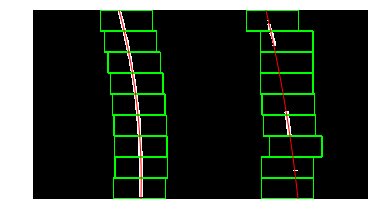

In [70]:
# Test sliding window search function
img = mpimg.imread('./test_images/test2.jpg')
h, w = img.shape[:2]
warped = cv2.warpPerspective(img, M, (w,h))
warped_binary = threshold_image(warped,  color_channel='V', color_threshold=(220,255))
ret, left_fit, right_fit, out_img = blind_search(warped_binary)
laney = np.linspace(0, h-1, h)
lanex_left = left_fit[0]*laney**2+left_fit[1]*laney+left_fit[2]
lanex_right = right_fit[0]*laney**2+right_fit[1]*laney+right_fit[2]
plt.imshow(out_img), plt.axis('off')
plt.plot(lanex_left, laney, 'r', lanex_right, laney, 'r', lw=1)
# plt.savefig('./output_images/color_fit.png')

In [85]:
def draw_lane(undist, left_fit, right_fit, lane_length, lane_width, Mint, Line=None):
    # Get the size of the image
    h, w = undist.shape[0], undist.shape[1] 
    # Visualize the sliding window and the lane lines
    ploty = np.linspace(0, h-1, h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define the lane line boundaries 
    left_line = np.transpose(np.vstack([left_fitx, ploty]))
    right_line = np.flipud(np.transpose(np.vstack([right_fitx, ploty])))
    line_pts = np.vstack([left_line, right_line])
    
    # Draw the lane line areas
    window_img = np.zeros_like(undist)
    cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(window_img, Mint, (w, h), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    
    
    # Compute the curvature of the lane and the position of the car
    # Convert the pixel space to real physical space
    x1 = left_fit[0]*h**2+left_fit[1]*h+left_fit[2]        #compute the distance between the two lane lines
    x2 = right_fit[0]*h**2+right_fit[1]*h+right_fit[2]
    ym_per_pixel = lane_length/h
    xm_per_pixel = lane_width/(x2-x1)
    
    # Fit the new polynomial 
    left_fit_cr = np.polyfit(ploty*ym_per_pixel,left_fitx*xm_per_pixel, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pixel, right_fitx*xm_per_pixel, 2)
    
    # Calculate the radius of curvature
    left_curverad = compute_curverad(left_fit_cr)
    right_curverad = compute_curverad(right_fit_cr)
    

    # Calculate the position of the car by calculating the difference between the midpoint of the lane and the midpoint 
    # of the image
    lane_center = (x1+x2)/2
    car_center = w/2
    offset = (lane_center-car_center)*xm_per_pixel
    
    # Embed the radius and position information into the output image
    if offset >= 0:
        pos_string = 'The car is {:.2f}m left of the center'.format(offset)
    else:
        pos_string = 'The car is {:.2f}m right of the center'.format(np.abs(offset))
    curve_string = 'The curvature is {:.1f}m'.format((left_curverad+right_curverad)/2)
    cv2.putText(result, pos_string, (200, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, color=[255,255,255], thickness = 2)
    cv2.putText(result, curve_string, (200, 100), cv2.FONT_HERSHEY_COMPLEX, 1.5, color=[255,255,255], thickness =2)
    
    # Combine the final results and the lane line finding process for easier trouble shooting
    if Line is not None:
        combo_img = np.vstack([Line.line_windows, result])
        result = combo_img
    
    return result

In [73]:
# Compute the real curvature in meters
def compute_curverad(polyfit):
    radius_of_curvature = ((1+(2*polyfit[0]*h*ym_per_pixel+polyfit[1])**2)**1.5)/np.abs(2*polyfit[0])
    return radius_of_curvature
def compute_car_pos(left_fit, right_fit):
    x1 = left_fit[0]*h**2+left_fit[1]*h+left_fit[2]        #compute the distance between the two lane lines
    x2 = right_fit[0]*h**2+right_fit[1]*h+right_fit[2]
    lane_center = (x1+x2)/2
    car_center = w/2
    offset = (lane_center-car_center)*xm_per_pixel
    return offset

In [74]:
class Line():
    def __init__(self):
        # Check whether the line was detected in the previous image or not
        self.detected = False
        # Store the polynomial coefficients of previous fittings
        self.fit_buffer = np.array([]).reshape(0,6)
        # Polynomial coefficients of the current fit
        self.current_fit = np.array([]).reshape(0,6)
        # Set a frame lost counter
        self.frame_lost = 0
        # Radius of curvature
        self.radius_of_curvature = None
        # Car location calculated by the offset from the lane center
        self.line_bas_pos = None   
        # Lane distance
        self.line_dist = None
        # Lane line search window
        self.line_windows = None

In [86]:
# Build the pipeline
# Set parameters
h = 720                       # Height of the image unit:pixel
color_channel='V'             # Color channel
color_threshold=(220,255)      # Threshold for color channel
blind_search_margin = 100     # Margin for blind window search
ajacent_search_margin = 100    # Margin for adjacent search
search_min_pixel = 50         # The minimum pixel to determine lane line points
lane_length=30                # The true lane line size
lane_width=3.7
frame_buffer = 5              # The number of lane line fitting values to store in a buffer
blind_search_threshold = 2    # The threshold, lower than which, blind search will be performed
curvature_diff_threshold = 1.0   # this is a ratio of the curvature difference and the smaller curvature
ym_per_pixel = lane_length/h
frame_lost_threshold=3        # The number of lost frames, beyond which, blind search will be performed
mean_curvature_thresh=(100, 2000)  # Curvature threshold used for sanity check
lane_dist_thresh=1200          # The distance between the lane lines, used to perform sanity check
# Persepctive transform params
# Four source points
src = np.float32(
      [[215, 705],
      [576, 460],
      [705, 460],
      [1098, 705]])

# Four destination points
dst = np.float32(
     [[350, 720],
      [350, 0],
      [950, 0],
      [950, 720]])

# Instantiate the Line class
LaneLine = Line()

# Load the camera matrix and undistortion coefficients or perform camera calibration if not done yet
camera_calibration_file = './undistortion.p'
mtx, dist = load_calibration_params(camera_calibration_file)
def pipeline(img):
    '''
    The pipeline takes an image as input, through thresholding, perspective transform, and lane line detecting. 
    
    Params:
    
    Return: visible lane line area, instant position and lane line curvature
    '''
    # Step 1, undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    h, w = undist.shape[:2]
    # Step 2, threshold the image to get a binary output
    binary = threshold_image(undist, color_channel, color_threshold)
    
    # Step 3, perspective transform
    M, Mint = transform_perspective(src, dst)
    warped_binary = cv2.warpPerspective(binary, M, (w, h), flags=cv2.INTER_LINEAR)

    # step 4, find the lane line
    ret, left_fit, right_fit, LaneLine.line_windows = blind_search(warped_binary, margin=blind_search_margin, minpixel=search_min_pixel)       
    
    if ret is True and sanity_check(left_fit, right_fit, mean_curvature_thresh, lane_dist_thresh) is 'pass':
        LaneLine.frame_lost = 0    # Reset the frame_lost count to zero once find the line
        LaneLine.current_fit = np.concatenate([left_fit, right_fit])
        # Stack the current fit to the buffer
        LaneLine.fit_buffer = np.vstack([LaneLine.fit_buffer, LaneLine.current_fit])
        LaneLine.detected = True
    else:
        LaneLine.frame_lost += 1
        LaneLine.detected = False
#         LaneLine.current_fit = LaneLine.fit_buffer[-1]
        
    # Keep the last 5 fittings
    LaneLine.fit_buffer = LaneLine.fit_buffer[-5:]
    
    # Step 5, compute the position and the road curvature with moving averaged fittings
    if LaneLine.detected is True:
        left_fit, right_fit = np.split(LaneLine.current_fit, 2) 
    elif LaneLine.fit_buffer.size>1:
        left_fit, right_fit = np.split(LaneLine.fit_buffer[-1],2)
    result = draw_lane(undist, left_fit, right_fit, lane_length, lane_width, Mint, LaneLine)
    return result 

CPU times: user 139 ms, sys: 4.72 ms, total: 143 ms
Wall time: 89.9 ms


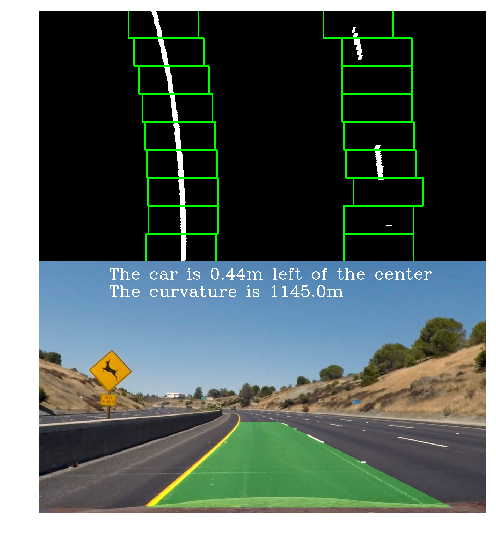

In [87]:
# Test the pipeline
image = mpimg.imread('./test_images/test2.jpg')
%time res = pipeline(image)
fig=plt.figure(figsize=(8,10))
plt.imshow(res), plt.axis('off')
# plt.savefig('./output_images/example_output.png')
LaneLine = Line()

In [88]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

def process_img(img):
    result = pipeline(img)
    return result
if not os.path.isdir('./video_output/'):
    os.mkdir('./video_output/')

white_output = 'project_video_output.mp4'

# clip1 = VideoFileClip('project_video.mp4').subclip(20,30)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:37<00:00,  8.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 58s, sys: 14.1 s, total: 3min 12s
Wall time: 2min 39s


In [89]:
HTML("""
<video width="800" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))